# Data mining and prediction

From data_explore.ipynb we already explore features and find some useful features in the dataset. in this part, we will mining modify these features and use them with some models to predict the totals_transactionRevenue.

##  Literature reviews

[Garbage Collection package](https://rushter.com/blog/python-garbage-collector/)

[XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/)

[LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/)

[Business Model Analysis for Online Social Shopping Companies Case Study: RunToShop Oy](http://epub.lib.aalto.fi/en/ethesis/pdf/12190/hse_ethesis_12190.pdf)

In [1]:
use_intermediate_results = True

In [2]:
import pandas as pd
import numpy as np
import json
from ast import literal_eval
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
#import gc
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## Load data

Firstly, as we alread found the useful features, I write a function to load these features in more effecient way.

In [1]:
use_features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber', 'visitStartTime', 
                'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
                'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 
                'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 
                'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
                'totals_timeOnSite', 'totals_transactionRevenue', 'totals_transactions',
                'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page','trafficSource_campaign', 
                'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 
                'trafficSource_referralPath', 'trafficSource_source', 'customDimensions_index', 
                'customDimensions_value']

As the dataset is very large, I try to use python's [Garbage collection package](https://rushter.com/blog/python-garbage-collector/) and read csv file in small chunks to reduce the memory when loading the data.

In [3]:
gc.enable()

In [5]:
def load_data(file_path):
    j_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    re_df = pd.DataFrame()
    dfs = pd.read_csv(file_path, converters={column: json.loads for column in j_col}, 
                      dtype={'fullVisitorId': 'str'}, chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in j_col:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        column_as_df = json_normalize(df['customDimensions'].apply(lambda x: literal_eval(x)[0] if x != "[]" else {'index': 'NaN', 'value': 'NaN'}))
        column_as_df.columns = [f"{'customDimensions'}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop('customDimensions', axis=1).merge(column_as_df, right_index=True, left_index=True)
        use_df = df[use_features]
        use_df['visitStartTime'] = pd.to_datetime(use_df['visitStartTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))
        use_df['year'] = use_df['visitStartTime'].apply(lambda x:x.year)
        use_df['month'] = use_df['visitStartTime'].apply(lambda x:x.month)
        use_df['day'] = use_df['visitStartTime'].apply(lambda x:x.day)
        use_df['weekday'] = use_df['visitStartTime'].apply(lambda x:x.weekday())
        del df
        gc.collect()
        re_df= pd.concat([re_df, use_df], axis=0).reset_index(drop=True)
    return re_df

In this load function, I also chage the 'visitStartTime' feature from the POSIX timestamp to readable time and create the time features, like year, month, day, weekday.

In [6]:
train_df = load_data('train_v2.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [7]:
train_df.shape

(1708337, 39)

After loading the data, there are 39 columns and 1,708,337 rows.

In [8]:
pd.set_option('display.max_columns', 40)

In [9]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_index,customDimensions_value,year,month,day,weekday
0,Organic Search,20171016,3162355547410993243,1508198450,1,2017-10-17 00:00:50,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google,4,EMEA,2017,10,17,1
1,Referral,20171016,8934116514970143966,1508176307,6,2017-10-16 17:51:47,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,4,North America,2017,10,16,0
2,Direct,20171016,7992466427990357681,1508201613,1,2017-10-17 00:53:33,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,1,38,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),4,North America,2017,10,17,1
3,Organic Search,20171016,9075655783635761930,1508169851,1,2017-10-16 16:04:11,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,1,1,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,EMEA,2017,10,16,0
4,Organic Search,20171016,6960673291025684308,1508190552,1,2017-10-16 21:49:12,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,1,52,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,4,Central America,2017,10,16,0


In the target value, the NaN values means the customer doesn't spend any money on this view, so I fill them with 0.

In [10]:
train_df['totals_transactionRevenue'].fillna(0, inplace=True)
train_df['totals_transactionRevenue']=pd.to_numeric(train_df['totals_transactionRevenue'])

In [11]:
train_df.dtypes

channelGrouping                                object
date                                            int64
fullVisitorId                                  object
visitId                                         int64
visitNumber                                     int64
visitStartTime                         datetime64[ns]
device_browser                                 object
device_deviceCategory                          object
device_isMobile                                  bool
device_operatingSystem                         object
geoNetwork_city                                object
geoNetwork_continent                           object
geoNetwork_country                             object
geoNetwork_metro                               object
geoNetwork_networkDomain                       object
geoNetwork_region                              object
geoNetwork_subContinent                        object
totals_bounces                                 object
totals_hits                 

Load the test dataset.

In [12]:
test_df = load_data('test_v2.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

As this project is a competition, there is no target value in test data. And for convenience and consistency when encoding object type values, I make the target values in test dataset equal to NaN.

In [13]:
test_df['totals_transactionRevenue'] = np.nan

Let's merge train data and test data together to handle the features.

In [14]:
big_df = train_df.append(test_df, sort=False).reset_index(drop=True)

## Data handling

First, let's check if there is NaN value in the big dataset.

In [15]:
null_cols = big_df.isnull().sum().sort_values()
print(null_cols[null_cols > 0])

totals_pageviews                           340
totals_transactionRevenue               401589
totals_newVisits                        516431
totals_sessionQualityDim                835274
totals_bounces                         1055670
totals_timeOnSite                      1057980
trafficSource_keyword                  1093006
trafficSource_referralPath             1142073
trafficSource_isTrueDirect             1426999
trafficSource_adContent                1643600
trafficSource_adwordsClickInfo.page    2024047
totals_transactions                    2085062
dtype: int64


Except the target value there are 11 columns have NaN values, fill them with different ways according to the columns theirself.

As the every customer should visit at least 1 page, so fill NaN values in this columns with 1.

In [16]:
big_df['totals_pageviews'].fillna(1, inplace=True)
big_df['totals_newVisits'].fillna(0, inplace=True)
big_df['totals_sessionQualityDim'].fillna(0, inplace=True)
big_df['totals_bounces'].fillna(0, inplace=True)
big_df['totals_timeOnSite'].fillna(0, inplace=True)
big_df['totals_transactions'].fillna(0, inplace=True)

In [17]:
big_df['trafficSource_keyword'].fillna('(not provided)', inplace=True)
big_df['trafficSource_referralPath'].fillna('/', inplace=True)
big_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
big_df['trafficSource_adContent'].fillna('unknown', inplace=True)
big_df['trafficSource_adwordsClickInfo.page'].fillna(0, inplace=True)

As other values in each columns, fill them with different values.

In [18]:
null_cols = big_df.isnull().sum().sort_values()
print(null_cols[null_cols > 0])

totals_transactionRevenue    401589
dtype: int64


There are some columns with integer, but them type is object, change them to integer.

In [19]:
big_df['totals_pageviews'] = big_df['totals_pageviews'].astype(int)
big_df['totals_newVisits'] = big_df['totals_newVisits'].astype(int)
big_df['totals_sessionQualityDim'] = big_df['totals_sessionQualityDim'].astype(int)
big_df['totals_bounces'] = big_df['totals_bounces'].astype(int)
big_df['totals_timeOnSite'] = big_df['totals_timeOnSite'].astype(int)
big_df['totals_transactions'] = big_df['totals_transactions'].astype(int)
big_df['totals_hits'] = big_df['totals_hits'].astype(int)
big_df['trafficSource_adwordsClickInfo.page'] = big_df['trafficSource_adwordsClickInfo.page'].astype(int)

In [20]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 39 columns):
channelGrouping                        object
date                                   int64
fullVisitorId                          object
visitId                                int64
visitNumber                            int64
visitStartTime                         datetime64[ns]
device_browser                         object
device_deviceCategory                  object
device_isMobile                        bool
device_operatingSystem                 object
geoNetwork_city                        object
geoNetwork_continent                   object
geoNetwork_country                     object
geoNetwork_metro                       object
geoNetwork_networkDomain               object
geoNetwork_region                      object
geoNetwork_subContinent                object
totals_bounces                         int64
totals_hits                            int64
totals_newVi

Now let's see the information of big datafram, the memory usage is only about 600 MB, which is much small than the origin datasets. And there are 20 object type columns we need to encode.

Before encode features, let's drop some columns we already used.

In [21]:
big_df.drop(['date','visitId','visitStartTime'], axis=1, inplace=True)

### Label Encoder

Chage the boolean columns, first.

In [23]:
big_df['trafficSource_isTrueDirect'] = big_df['trafficSource_isTrueDirect'].astype(int)
big_df['device_isMobile'] = big_df['device_isMobile'].astype(int)

Before encoding, let's list all columns with object type.

In [24]:
le_col = []
for c, t in big_df.loc[:,big_df.columns].dtypes.iteritems():
    if t =='object' and (c != 'fullVisitorId' and c != 'totals_transactionRevenue'):
        le_col.append(c)

In [25]:
le_col

['channelGrouping',
 'device_browser',
 'device_deviceCategory',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'trafficSource_adContent',
 'trafficSource_campaign',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source',
 'customDimensions_index',
 'customDimensions_value']

Use LabelEncoder function in sklearn library to encode object values in object columns.

In [28]:
for col in le_col:
    le = LabelEncoder()
    big_df[col] = le.fit_transform(big_df[col])

In [4]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 36 columns):
channelGrouping                        int64
fullVisitorId                          object
visitNumber                            int64
device_browser                         int64
device_deviceCategory                  int64
device_isMobile                        int64
device_operatingSystem                 int64
geoNetwork_city                        int64
geoNetwork_continent                   int64
geoNetwork_country                     int64
geoNetwork_metro                       int64
geoNetwork_networkDomain               int64
geoNetwork_region                      int64
geoNetwork_subContinent                int64
totals_bounces                         int64
totals_hits                            int64
totals_newVisits                       int64
totals_pageviews                       int64
totals_sessionQualityDim               int64
totals_timeOnSite              

Now as expect, all columns' type is numeric, except fullVisitorId.

In [31]:
if use_intermediate_results == False:
    big_df.to_pickle('big_data.pkl')

In [3]:
if use_intermediate_results == True:
    big_df = pd.read_pickle('big_data.pkl')

### Groupe every customer with their ID

The target is to predict every customer revenue in the Gstore, and row in the datasets is the record of every view of every customer. So we should combine all views belong to same customer (same fullVisitorId).

When merge rows with same fullVisitorId, we need to decide what to do with columns. I use some diferent ways to different columns to get better result.

In [20]:
to_median = ['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_isMobile', 
             'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 
             'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 
             'geoNetwork_subContinent', 'trafficSource_adContent', 
             'trafficSource_adwordsClickInfo.page', 'trafficSource_campaign', 
             'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 
             'trafficSource_referralPath', 'trafficSource_source', 'customDimensions_index', 
             'customDimensions_value', 'year', 'month', 'day', 'weekday']
to_sum = ['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 
          'totals_timeOnSite', 'totals_transactions']
to_mean = ['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 
           'totals_sessionQualityDim', 'totals_timeOnSite']
to_std = ['totals_bounces', 'totals_hits', 'totals_pageviews', 'totals_timeOnSite']

Like channelGrouping and device_browser columns, get their median value is enough, and for totals_bounces and some other columns I get their sum, mean and standard deviation.

When we do lable encoding, we merge train data and test data together to keep the consistency. But after that, we should not group customer both in train set and test set, so I split them.

In [21]:
train_df = big_df[big_df['totals_transactionRevenue'].notnull()]
test_df = big_df[big_df['totals_transactionRevenue'].isnull()].drop(['totals_transactionRevenue'], axis=1)

In [22]:
train_df.shape

(1708337, 36)

In [23]:
test_df.shape

(401589, 35)

They have same shape as before, means we are doing right thing.

In [44]:
train = train_df.groupby('fullVisitorId')[to_median].median().add_suffix('_median')
sum_df = train_df.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum')
mean_df = train_df.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean')
std_df = train_df.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std')

In [45]:
train = train.merge(sum_df.reset_index(),how='left', on='fullVisitorId')
train = train.merge(mean_df.reset_index(),how='left', on='fullVisitorId')
train = train.merge(std_df.reset_index(),how='left', on='fullVisitorId')
train = train.merge(train_df.groupby('fullVisitorId')['totals_transactionRevenue'].sum().reset_index(),how='left', on='fullVisitorId')

In [46]:
train.head()

,fullVisitorId,channelGrouping_median,device_browser_median,device_deviceCategory_median,device_isMobile_median,device_operatingSystem_median,geoNetwork_city_median,geoNetwork_continent_median,geoNetwork_country_median,geoNetwork_metro_median,...,totals_hits_mean,totals_newVisits_mean,totals_pageviews_mean,totals_sessionQualityDim_mean,totals_timeOnSite_mean,totals_bounces_std,totals_hits_std,totals_pageviews_std,totals_timeOnSite_std,totals_transactionRevenue
0,0000000259678714014,4.0,55.0,0.0,0.0,7.0,621.0,2.0,219.0,104.0,...,9.5,0.5,6.5,6.0,64.5,0.0,6.5,3.5,7.5,0.0
1,0000010278554503158,4.0,55.0,0.0,0.0,7.0,1096.0,5.0,146.0,129.0,...,11.0,1.0,8.0,0.0,194.0,0.0,0.0,0.0,0.0,0.0
2,0000020424342248747,4.0,55.0,0.0,0.0,22.0,490.0,2.0,160.0,0.0,...,17.0,1.0,13.0,0.0,297.0,0.0,0.0,0.0,0.0,0.0
3,0000027376579751715,4.0,55.0,0.0,0.0,7.0,1096.0,2.0,219.0,129.0,...,6.0,1.0,5.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0
4,0000039460501403861,7.0,55.0,0.0,0.0,22.0,1096.0,2.0,28.0,129.0,...,2.0,1.0,2.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.shape

(1323730, 45)

In [47]:
if use_intermediate_results == False:
    train.to_pickle('train.pkl')

In [4]:
if use_intermediate_results == True:
    train = pd.read_pickle('train.pkl')

After complete train set, let's do the same thing in test set.

In [28]:
test = test_df.groupby('fullVisitorId')[to_median].median().add_suffix('_median')
sum_df = test_df.groupby('fullVisitorId')[to_sum].sum().add_suffix('_sum')
mean_df = test_df.groupby('fullVisitorId')[to_mean].mean().add_suffix('_mean')
std_df = test_df.groupby('fullVisitorId')[to_std].std(ddof=0).add_suffix('_std')

In [29]:
test = test.merge(sum_df.reset_index(),how='left', on='fullVisitorId')
test = test.merge(mean_df.reset_index(),how='left', on='fullVisitorId')
test = test.merge(std_df.reset_index(),how='left', on='fullVisitorId')

In [36]:
test.head()

,fullVisitorId,channelGrouping_median,device_browser_median,device_deviceCategory_median,device_isMobile_median,device_operatingSystem_median,geoNetwork_city_median,geoNetwork_continent_median,geoNetwork_country_median,geoNetwork_metro_median,...,totals_bounces_mean,totals_hits_mean,totals_newVisits_mean,totals_pageviews_mean,totals_sessionQualityDim_mean,totals_timeOnSite_mean,totals_bounces_std,totals_hits_std,totals_pageviews_std,totals_timeOnSite_std
0,0000018966949534117,4.0,55.0,0.0,0.0,7.0,861.0,2.0,219.0,104.0,...,0.0,7.0,1.0,7.0,1.0,131.0,0.0,0.0,0.0,0.0
1,0000039738481224681,2.0,55.0,1.0,1.0,1.0,1096.0,2.0,219.0,129.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0000073585230191399,4.0,102.0,1.0,1.0,25.0,1096.0,2.0,219.0,129.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0000087588448856385,4.0,55.0,0.0,0.0,22.0,1096.0,3.0,202.0,129.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0000149787903119437,4.0,55.0,1.0,1.0,1.0,1096.0,4.0,174.0,129.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
if use_intermediate_results == False:
    test.to_pickle('test.pkl')

In [3]:
if use_intermediate_results == True:
    test = pd.read_pickle('test.pkl')

## Prediction

In [5]:
X = train.drop(['fullVisitorId','totals_transactionRevenue'], axis=1)

We are predicting the natural log of the sum of all transactions per user. 

For every user in the test set, the target is: 
$$ target_{user}=ln(y_{user}+1)$$

So let's use the equation to change y in train set.

In [6]:
y = np.log1p(train['totals_transactionRevenue'])

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

Use $train\_test\_split()$ function to split the train set to train subset and validation subset.

In [8]:
random_state = 0
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=.2, random_state=random_state)

As what we see in Data explore part, the $98.9\%$  of value we will predict is NaN, it we use decision tree to split data in to NaN and not NaN for some features, and continue to predict the value may be a good idea, so model like random forest and xgboost may have good performance. And as experience, the xgboost perform very well in machine learning. So I try to use this model to predict first.

In [154]:
params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'learning_rate': 0.015,
        'max_depth': 10,
        'min_child_weight': 40,
        'gamma' : 1.45,
        'alpha': 5.0,
        'lambda': 1.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456,
        'importance_type': 'total_gain',
        'n_estimators':70
    }

In [155]:
xgb_reg = xgb.XGBRegressor(**params)
xgb_reg

XGBRegressor(alpha=5.0, base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.054,
       gamma=1.45, importance_type='total_gain', lambda=1.0,
       learning_rate=0.015, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=70, n_jobs=-1,
       nthread=None, objective='reg:squarederror', random_state=456,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.67, verbosity=1)

In [156]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],eval_metric='rmse')

[0]	validation_0-rmse:1.94877	validation_1-rmse:1.95123
[1]	validation_0-rmse:1.94391	validation_1-rmse:1.94617
[2]	validation_0-rmse:1.9438	validation_1-rmse:1.94462
[3]	validation_0-rmse:1.94409	validation_1-rmse:1.94462
[4]	validation_0-rmse:1.94407	validation_1-rmse:1.94408
[5]	validation_0-rmse:1.93626	validation_1-rmse:1.93239
[6]	validation_0-rmse:1.9361	validation_1-rmse:1.93165
[7]	validation_0-rmse:1.9321	validation_1-rmse:1.927
[8]	validation_0-rmse:1.92921	validation_1-rmse:1.92336
[9]	validation_0-rmse:1.9293	validation_1-rmse:1.923
[10]	validation_0-rmse:1.9249	validation_1-rmse:1.91912
[11]	validation_0-rmse:1.923	validation_1-rmse:1.91905
[12]	validation_0-rmse:1.92195	validation_1-rmse:1.919
[13]	validation_0-rmse:1.89297	validation_1-rmse:1.8912
[14]	validation_0-rmse:1.89241	validation_1-rmse:1.8909
[15]	validation_0-rmse:1.89138	validation_1-rmse:1.88962
[16]	validation_0-rmse:1.89106	validation_1-rmse:1.88923
[17]	validation_0-rmse:1.89066	validation_1-rmse:1.88857

XGBRegressor(alpha=5.0, base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.054,
       gamma=1.45, importance_type='total_gain', lambda=1.0,
       learning_rate=0.015, max_delta_step=0, max_depth=10,
       min_child_weight=40, missing=None, n_estimators=70, n_jobs=-1,
       nthread=None, objective='reg:squarederror', random_state=456,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.67, verbosity=1)

In [157]:
results = xgb_reg.evals_result()

In [158]:
n_iter = len(results['validation_0']['rmse'])
n_iter

70

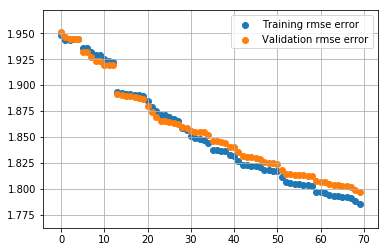

In [159]:
plt.scatter(list(range(n_iter)), results['validation_0']['rmse'], label='Training rmse error')
plt.scatter(list(range(n_iter)), results['validation_1']['rmse'], label='Validation rmse error')
plt.grid(True)
plt.legend()

From the the root-mean-square-error plot we can see, as the iteration increase, both Training rmse and Validation rmse are becoming smaller, and Training rmse is getting colser to Validation rmse, but with iteration increase further, may overfitting, so I choose the number of iteration is 70.

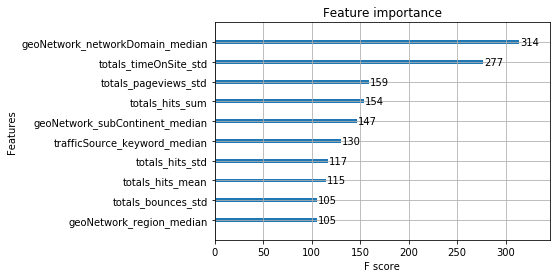

In [160]:
xgb.plot_importance(xgb_reg,max_num_features=10)

From the feature importance plot, we can see the geoNetwork_networkDomain is most important, which means the geography of a customer. The second important feature is totals_timeInSite, which means how long this customer view in Gstore. The totals_pageviews is third important, which how many pages this custiomer view on site. And the totals_hits feature is also very important.

In [161]:
X_test = test.drop(['fullVisitorId'], axis=1)

Let's use fitted model to predict the target value in test set.

In [162]:
y_pred = xgb_reg.predict(X_test)

In [163]:
y_pred[y_pred < 0] = 0.0

In [164]:
test['PredictedLogRevenue'] = y_pred

Save the result as required format.

In [165]:
sub = test[['fullVisitorId','PredictedLogRevenue']]

In [166]:
sub.to_csv("submission.csv", index=False)

I tried to use GridSearchCV to tune parameters, but because the data set is too large and the power of my laptop is not good enough, the auto tuning process will take much time, so I only manual tuned parameters, and after several times, I got the best score in Kaggle is 0.95822, the rank of it is about 361, and I can get the Bronze.

 <img src= "best_score.png">

 <img src= "rank.png">

### Error analysis

As I don't use the hits columns, and I discard some columns look like useless (truth may be not), the prediction result is not good enough. The methods I group the same ID can also be improved to get a better result.

### Other models

I also tried some other models, but their result are not better than xgboost.

In [2]:
import lightgbm as lgb

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [11]:
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9,
        "random_state":42,
        'max_depth': 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "bagging_frequency" : 5,
        'lambda_l2': 0.5,
        'lambda_l1': 0.5,
        'min_child_samples': 36
       }

In [13]:
reg = lgb.LGBMRegressor(**params,n_estimators=100)

In [24]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],eval_metric='rmse')

[1]	training's rmse: 1.94108	valid_1's rmse: 1.92114
Training until validation scores don't improve for 50 rounds.
[2]	training's rmse: 1.92178	valid_1's rmse: 1.90205
[3]	training's rmse: 1.90267	valid_1's rmse: 1.88315
[4]	training's rmse: 1.88376	valid_1's rmse: 1.86444
[5]	training's rmse: 1.86503	valid_1's rmse: 1.84592
[6]	training's rmse: 1.8465	valid_1's rmse: 1.82759
[7]	training's rmse: 1.82815	valid_1's rmse: 1.80944
[8]	training's rmse: 1.80998	valid_1's rmse: 1.79147
[9]	training's rmse: 1.792	valid_1's rmse: 1.77369
[10]	training's rmse: 1.78594	valid_1's rmse: 1.76764
[11]	training's rmse: 1.7682	valid_1's rmse: 1.7501
[12]	training's rmse: 1.76225	valid_1's rmse: 1.74416
[13]	training's rmse: 1.75651	valid_1's rmse: 1.73845
[14]	training's rmse: 1.73906	valid_1's rmse: 1.7212
[15]	training's rmse: 1.73348	valid_1's rmse: 1.71567
[16]	training's rmse: 1.71627	valid_1's rmse: 1.69865
[17]	training's rmse: 1.69923	valid_1's rmse: 1.6818
[18]	training's rmse: 1.68236	valid_

[152]	training's rmse: 0.491474	valid_1's rmse: 0.491498
[153]	training's rmse: 0.486958	valid_1's rmse: 0.487095
[154]	training's rmse: 0.482492	valid_1's rmse: 0.482744
[155]	training's rmse: 0.478073	valid_1's rmse: 0.478443
[156]	training's rmse: 0.473702	valid_1's rmse: 0.474187
[157]	training's rmse: 0.469379	valid_1's rmse: 0.469979
[158]	training's rmse: 0.465102	valid_1's rmse: 0.465818
[159]	training's rmse: 0.460872	valid_1's rmse: 0.461706
[160]	training's rmse: 0.456687	valid_1's rmse: 0.457638
[161]	training's rmse: 0.45255	valid_1's rmse: 0.453615
[162]	training's rmse: 0.448457	valid_1's rmse: 0.449643
[163]	training's rmse: 0.444408	valid_1's rmse: 0.445713
[164]	training's rmse: 0.440404	valid_1's rmse: 0.441824
[165]	training's rmse: 0.436443	valid_1's rmse: 0.43798
[166]	training's rmse: 0.432526	valid_1's rmse: 0.434178
[167]	training's rmse: 0.428652	valid_1's rmse: 0.430422
[168]	training's rmse: 0.424821	valid_1's rmse: 0.426707
[169]	training's rmse: 0.421032	v

[302]	training's rmse: 0.186015	valid_1's rmse: 0.20218
[303]	training's rmse: 0.185853	valid_1's rmse: 0.202049
[304]	training's rmse: 0.185015	valid_1's rmse: 0.201314
[305]	training's rmse: 0.18419	valid_1's rmse: 0.200589
[306]	training's rmse: 0.184032	valid_1's rmse: 0.200465
[307]	training's rmse: 0.183224	valid_1's rmse: 0.199756
[308]	training's rmse: 0.182424	valid_1's rmse: 0.199058
[309]	training's rmse: 0.181636	valid_1's rmse: 0.198376
[310]	training's rmse: 0.18086	valid_1's rmse: 0.1977
[311]	training's rmse: 0.180096	valid_1's rmse: 0.197034
[312]	training's rmse: 0.179346	valid_1's rmse: 0.196386
[313]	training's rmse: 0.178606	valid_1's rmse: 0.195743
[314]	training's rmse: 0.177879	valid_1's rmse: 0.195119
[315]	training's rmse: 0.177163	valid_1's rmse: 0.194498
[316]	training's rmse: 0.176456	valid_1's rmse: 0.193887
[317]	training's rmse: 0.175759	valid_1's rmse: 0.19329
[318]	training's rmse: 0.175072	valid_1's rmse: 0.192699
[319]	training's rmse: 0.174944	valid

[451]	training's rmse: 0.139877	valid_1's rmse: 0.163976
[452]	training's rmse: 0.1398	valid_1's rmse: 0.163922
[453]	training's rmse: 0.139781	valid_1's rmse: 0.163912
[454]	training's rmse: 0.1397	valid_1's rmse: 0.163861
[455]	training's rmse: 0.139622	valid_1's rmse: 0.163805
[456]	training's rmse: 0.139543	valid_1's rmse: 0.163751
[457]	training's rmse: 0.139469	valid_1's rmse: 0.163704
[458]	training's rmse: 0.139397	valid_1's rmse: 0.163653
[459]	training's rmse: 0.139324	valid_1's rmse: 0.163597
[460]	training's rmse: 0.139307	valid_1's rmse: 0.163589
[461]	training's rmse: 0.139289	valid_1's rmse: 0.163581
[462]	training's rmse: 0.139218	valid_1's rmse: 0.163529
[463]	training's rmse: 0.13915	valid_1's rmse: 0.163478
[464]	training's rmse: 0.139082	valid_1's rmse: 0.163427
[465]	training's rmse: 0.139016	valid_1's rmse: 0.163382
[466]	training's rmse: 0.139	valid_1's rmse: 0.163374
[467]	training's rmse: 0.138937	valid_1's rmse: 0.163326
[468]	training's rmse: 0.138875	valid_1

[602]	training's rmse: 0.135109	valid_1's rmse: 0.16112
[603]	training's rmse: 0.135099	valid_1's rmse: 0.161115
[604]	training's rmse: 0.135084	valid_1's rmse: 0.161107
[605]	training's rmse: 0.135072	valid_1's rmse: 0.161104
[606]	training's rmse: 0.135057	valid_1's rmse: 0.161101
[607]	training's rmse: 0.13504	valid_1's rmse: 0.161096
[608]	training's rmse: 0.135032	valid_1's rmse: 0.161094
[609]	training's rmse: 0.135008	valid_1's rmse: 0.161089
[610]	training's rmse: 0.134994	valid_1's rmse: 0.161087
[611]	training's rmse: 0.134985	valid_1's rmse: 0.161083
[612]	training's rmse: 0.134971	valid_1's rmse: 0.161077
[613]	training's rmse: 0.134956	valid_1's rmse: 0.16107
[614]	training's rmse: 0.134949	valid_1's rmse: 0.161066
[615]	training's rmse: 0.134938	valid_1's rmse: 0.161064
[616]	training's rmse: 0.13493	valid_1's rmse: 0.161061
[617]	training's rmse: 0.134923	valid_1's rmse: 0.16106
[618]	training's rmse: 0.134907	valid_1's rmse: 0.161057
[619]	training's rmse: 0.134896	vali

[752]	training's rmse: 0.133658	valid_1's rmse: 0.16069
[753]	training's rmse: 0.133647	valid_1's rmse: 0.160686
[754]	training's rmse: 0.133636	valid_1's rmse: 0.160682
[755]	training's rmse: 0.133631	valid_1's rmse: 0.160684
[756]	training's rmse: 0.133622	valid_1's rmse: 0.160685
[757]	training's rmse: 0.133613	valid_1's rmse: 0.160682
[758]	training's rmse: 0.133603	valid_1's rmse: 0.160679
[759]	training's rmse: 0.133599	valid_1's rmse: 0.160679
[760]	training's rmse: 0.133589	valid_1's rmse: 0.160676
[761]	training's rmse: 0.13358	valid_1's rmse: 0.160672
[762]	training's rmse: 0.133568	valid_1's rmse: 0.160668
[763]	training's rmse: 0.133559	valid_1's rmse: 0.160665
[764]	training's rmse: 0.133549	valid_1's rmse: 0.160661
[765]	training's rmse: 0.13354	valid_1's rmse: 0.160658
[766]	training's rmse: 0.133529	valid_1's rmse: 0.160656
[767]	training's rmse: 0.133521	valid_1's rmse: 0.160653
[768]	training's rmse: 0.133512	valid_1's rmse: 0.16065
[769]	training's rmse: 0.133504	val

[897]	training's rmse: 0.132813	valid_1's rmse: 0.160541
[898]	training's rmse: 0.132808	valid_1's rmse: 0.160543
[899]	training's rmse: 0.132806	valid_1's rmse: 0.160542
[900]	training's rmse: 0.132805	valid_1's rmse: 0.160542
[901]	training's rmse: 0.132802	valid_1's rmse: 0.160541
[902]	training's rmse: 0.132794	valid_1's rmse: 0.160541
[903]	training's rmse: 0.132793	valid_1's rmse: 0.16054
[904]	training's rmse: 0.132787	valid_1's rmse: 0.160543
[905]	training's rmse: 0.132778	valid_1's rmse: 0.160542
[906]	training's rmse: 0.132776	valid_1's rmse: 0.16054
[907]	training's rmse: 0.132775	valid_1's rmse: 0.160541
[908]	training's rmse: 0.132769	valid_1's rmse: 0.160543
[909]	training's rmse: 0.132759	valid_1's rmse: 0.160539
[910]	training's rmse: 0.132758	valid_1's rmse: 0.160539
[911]	training's rmse: 0.132756	valid_1's rmse: 0.160539
[912]	training's rmse: 0.132746	valid_1's rmse: 0.160542
[913]	training's rmse: 0.132738	valid_1's rmse: 0.160542
[914]	training's rmse: 0.132727	v

LGBMRegressor(bagging_fraction=0.9, bagging_frequency=5, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.9, importance_type='split', lambda_l1=0.5,
       lambda_l2=0.5, learning_rate=0.01, max_depth=5, metric='rmse',
       min_child_samples=36, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1100, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1, verbosity=-1)

In [25]:
lgb_preds = reg.predict(X_test, num_iteration=reg.best_iteration_)

In [26]:
lgb_preds[lgb_preds < 0] = 0.0

In [27]:
test['PredictedLogRevenue'] = lgb_preds

In [28]:
sub = test[['fullVisitorId','PredictedLogRevenue']]

In [29]:
sub.to_csv("lgb_submission.csv", index=False)

## Conclusion

I think the score I get can be further improved, if I continue tune parameters or with better data mining process, but the cost is time. It's a pity that I don't have more time to continue, hope I can review this project in the future. 